In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('apartments_final.csv')

In [3]:
df.head()

,url,listing_id,zipcode,monthly_rent,bedrooms,bathrooms,square_feet,walk_score,transit_score,deposit,latitude,longitude,neighborhood,nbhd
0,https://www.apartments.com/2372-beckwith-dr-in...,ze0jqwy,46218,751,2,1.0,679,25,33,705,39.80125,-86.12643,Martindale-Brightwood,Martindale-Brightwood
1,https://www.apartments.com/7491-n-shadeland-av...,s34dq64,46250,1795,3,2.0,2500,54,33,1795,39.89034,-86.04540,I-69 Fall Creek,I-69 Fall Creek
2,https://www.apartments.com/nice-3-bedroom-ranc...,n669z9m,46237,1095,3,1.0,1439,29,32,1095,39.72238,-86.12113,University Heights,University Heights
3,https://www.apartments.com/1102-n-oakland-ave-...,c4kr5zf,46201,1300,3,1.5,1500,67,38,800,39.78265,-86.11278,Near Eastside,Near Eastside
4,https://www.apartments.com/634-e-10th-st-india...,rl2dfp0,46202,1600,2,2.0,1400,74,53,1600,39.78089,-86.14610,Chatham Arch,Chatham Arch


The goal is to predict monthly rent of an apartment using the following features: 

Features we must include:
- Bedrooms
- Bathrooms
- Square Feet
- Neighborhood

Optional features:
- Longitude
- ZIP
- Walk score
- Transit score


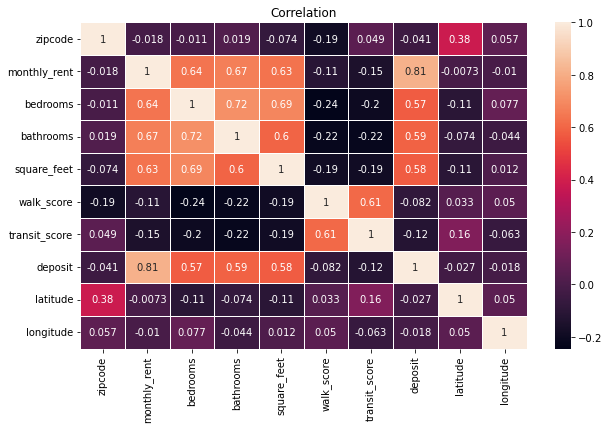

In [4]:
ax, fig= plt.subplots(figsize=(10,6))
ax= sns.heatmap(data=df.corr(), annot=True, linewidth=1);

ax.set_title('Correlation');

In [5]:
#feature interaction
#chose feature interaction for correlations higher than .6
df['bedbath']=df['bedrooms']*df['bathrooms']
df['sqft_bed']=df['square_feet']*df['bedrooms']
df['sqft_bath']=df['square_feet']*df['bathrooms']

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [7]:
#the function picks out the top 10% of neighborhoods listings
df['nbhd']=df['neighborhood']
nbhd_counts=df['neighborhood'].value_counts()

top_10p=np.percentile(nbhd_counts, 90)
print(top_10p)

def nbhd_count(nbhd):
        if len(df[df.neighborhood == nbhd])>top_10p:
            return nbhd
        else:
            return 'Other'

17.0


In [8]:
#apply the nbhd_count function to sort out the top 10% of popular neighborhoods in the nbhd column
df['nbhd']=df['nbhd'].apply(nbhd_count)

In [9]:
#Use the dictionary to turn the nbhd column into unique numerical values for the top 10% of neighborhoods
dict = {'Augusta':1
        ,'Eagle Creek':2
        ,'East Warren':3
        ,'Far Eastside':4
        ,'Indianapolis':5
        ,'Near Eastside':6
        ,'Other':0
        ,'Snacks Guion Creek':7
        ,'South Emerson':8
        ,'South Perry':9}

df['nbhd_number']=df['nbhd']
df.nbhd_number = df.nbhd_number.replace(dict)

In [10]:
#Use the dictionary to do one-hot encoding for the top 10% neighborhood and other category
dict_2 = {'Augusta':1
        ,'Eagle Creek':1
        ,'East Warren':1
        ,'Far Eastside':1
        ,'Indianapolis':1
        ,'Near Eastside':1
        ,'Other':0
        ,'Snacks Guion Creek':1
        ,'South Emerson':1
        ,'South Perry':1}

df['nbhd_top']=df['nbhd']
df.nbhd_top = df.nbhd_top.replace(dict_2)

In [11]:
df.head()

,url,listing_id,zipcode,monthly_rent,bedrooms,bathrooms,square_feet,walk_score,transit_score,deposit,latitude,longitude,neighborhood,nbhd,bedbath,sqft_bed,sqft_bath,nbhd_number,nbhd_top
0,https://www.apartments.com/2372-beckwith-dr-in...,ze0jqwy,46218,751,2,1.0,679,25,33,705,39.80125,-86.12643,Martindale-Brightwood,Other,2.0,1358,679.0,0,0
1,https://www.apartments.com/7491-n-shadeland-av...,s34dq64,46250,1795,3,2.0,2500,54,33,1795,39.89034,-86.04540,I-69 Fall Creek,Other,6.0,7500,5000.0,0,0
2,https://www.apartments.com/nice-3-bedroom-ranc...,n669z9m,46237,1095,3,1.0,1439,29,32,1095,39.72238,-86.12113,University Heights,Other,3.0,4317,1439.0,0,0
3,https://www.apartments.com/1102-n-oakland-ave-...,c4kr5zf,46201,1300,3,1.5,1500,67,38,800,39.78265,-86.11278,Near Eastside,Near Eastside,4.5,4500,2250.0,6,1
4,https://www.apartments.com/634-e-10th-st-india...,rl2dfp0,46202,1600,2,2.0,1400,74,53,1600,39.78089,-86.14610,Chatham Arch,Other,4.0,2800,2800.0,0,0


In [12]:
#Define power set function to make it easier for choosing a model
def get_subsets(fullset):
  listrep = list(fullset)
  n = len(listrep)
  return [[listrep[k] for k in range(n) if i&1<<k] for i in range(2**n)]


In [13]:
apt_train, apt_test = train_test_split(df.copy(),
                                        shuffle = True,
                                        random_state = 626,
                                        test_size=.2)

In [14]:
kfold = KFold(n_splits=10, shuffle=True, random_state=4530)

In [15]:
#Getting the list of models.
col_list=['bedrooms'
          ,'bathrooms'
          ,'square_feet'
          , 'walk_score'
          , 'transit_score'
          ,'bedbath'
          ,'nbhd_top'
         ,'sqft_bed'
          ,'sqft_bath']

set(col_list)
models=get_subsets(col_list)

#delete the empty set
del models[0]

#add in the baseline
models.append('baseline')


In [16]:
cv_mses = np.zeros((10, len(models)))

i = 0
for train_index, test_index in kfold.split(apt_train):
    apt_tt = apt_train.iloc[train_index]
    apt_holdout = apt_train.iloc[test_index]
    j = 0
    for model in models:
        if model == "baseline":
            train_mean = apt_tt.monthly_rent.mean()
            cv_mses[i,j] = mean_squared_error(apt_holdout.monthly_rent, train_mean*np.ones(len(apt_holdout)))
        else:
            reg = LinearRegression(copy_X = True)
            reg.fit(apt_tt[model], apt_tt.monthly_rent)
            cv_mses[i,j] = mean_squared_error(apt_holdout.monthly_rent, reg.predict(apt_holdout[model]))
        j = j + 1
    i = i + 1

In [17]:
#check to see which model has the lowest mse
models[np.argmin(np.mean(cv_mses, axis=0))]

['bedrooms', 'bathrooms', 'walk_score', 'bedbath', 'nbhd_top', 'sqft_bath']

In [18]:
low_mse_model=models[np.argmin(np.mean(cv_mses, axis=0))]

In [19]:
reg.fit(apt_test[low_mse_model], apt_test.monthly_rent)
y_pred=reg.predict(apt_test[low_mse_model])

In [20]:
print('MAE:',metrics.mean_absolute_error(apt_test.monthly_rent, reg.predict(apt_test[low_mse_model])))

print('MSE:',mean_squared_error(apt_test.monthly_rent, reg.predict(apt_test[low_mse_model])))
print('RMSE:',np.sqrt(mean_squared_error(apt_test.monthly_rent, reg.predict(apt_test[low_mse_model]))))

MAE: 215.98081095397615
MSE: 78401.04265834285
RMSE: 280.0018618837076


In [21]:
baseline=apt_test.monthly_rent.mean()
print('Baseline MSE: ',mean_squared_error(apt_test.monthly_rent, baseline*np.ones(len(apt_test))))
print('Baseline RMSE:', np.sqrt(mean_squared_error(apt_test.monthly_rent, baseline*np.ones(len(apt_test)))))

Baseline MSE:  214680.972277551
Baseline RMSE: 463.3367806224226


In [22]:
print(metrics.r2_score(apt_test.monthly_rent,y_pred))

0.6348020887618219


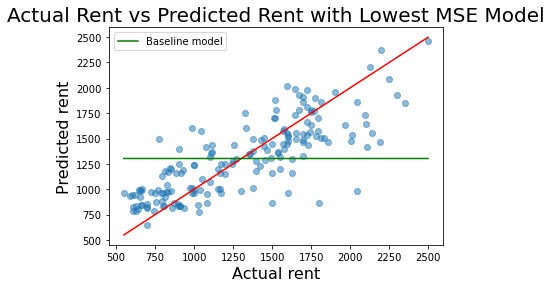

In [23]:
x=range(min(apt_test.monthly_rent.values),max(apt_test.monthly_rent.values))
y=x
plt.scatter(apt_test.monthly_rent,
               y_pred,alpha=.5)
plt.plot(x, y,color='red')
plt.plot(x, baseline*np.ones(len(x)), color='green',label='Baseline model')
plt.title('Actual Rent vs Predicted Rent with Lowest MSE Model', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel("Actual rent", fontsize=16)
plt.ylabel("Predicted rent", fontsize=16)

plt.show()

Text(0, 0.5, 'Predicted Rent [$]')

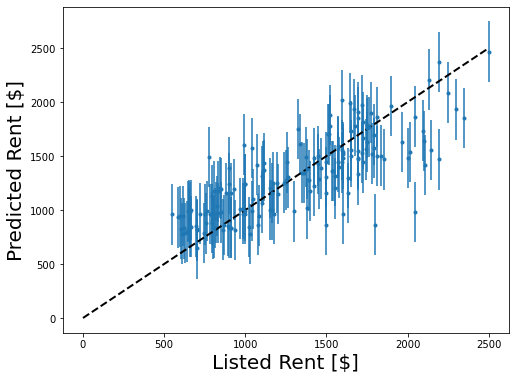

In [24]:
model_var=mean_squared_error(apt_test.monthly_rent, reg.predict(apt_test[low_mse_model]))
plt.figure(figsize=(8,6))

plt.rc('axes', labelsize=20)
plt.errorbar(apt_test.monthly_rent.values,y_pred, yerr=model_var**0.5, linestyle="", marker=".")
plt.plot(range(2500), range(2500), linestyle="--", linewidth="2", color="k")
plt.xlabel("Listed Rent [$]")
plt.ylabel("Predicted Rent [$]")


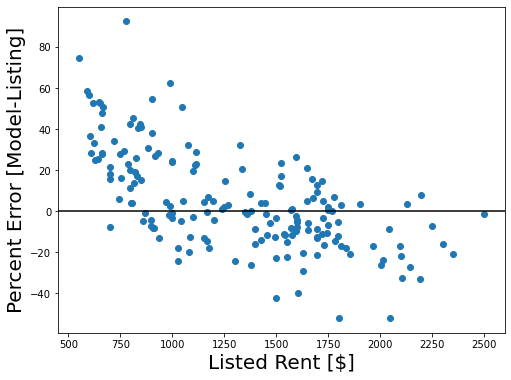

In [25]:
plt.figure(figsize=(8,6))

plt.scatter(apt_test.monthly_rent.values, (y_pred-apt_test.monthly_rent.values)*100/apt_test.monthly_rent.values)
plt.xlabel("Listed Rent [$]")
plt.ylabel("Percent Error [Model-Listing]")
plt.axhline(0, c="k")